**Load Standard Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import numba as nb

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline
sns.set()

### Load Bitstamp Btc data

Note this is sourced from: http://api.bitcoincharts.com/v1/csv/

See SO post for more detail: https://stackoverflow.com/questions/16143266/get-bitcoin-historical-data

In [24]:
downloads_path = os.path.expanduser('~/Downloads')
btc_data = pd.read_csv(os.path.join(downloads_path, "bitstampUSD.csv"), header=None)
btc_data.columns = ["TimeStamp", "Price", "Volume"]

**Clean and only subset of recent data**

In [32]:
start_date = "2017-03-07"
end_date = "2020-03-07"

In [25]:
btc_data['TimeStamp'] = pd.to_datetime(btc_data['TimeStamp'], unit='s')
btc_data.set_index("TimeStamp", inplace=True)
btc_data = btc_data.loc[(btc_data.index > start_date) & (btc_data.index <= end_date)]

In [26]:
btc_data.shape

(26692978, 2)

In [27]:
btc_data.head(3)

,Price,Volume
TimeStamp,,
2017-03-07 00:00:06,1278.49,0.010000
2017-03-07 00:00:14,1278.12,0.017039
2017-03-07 00:00:49,1278.02,2.000000


### Get OHLC data

In [38]:
%%time
ohlc_data = pd.DataFrame()

# Group by minute and get OHLC
grp_btc_data = btc_data.groupby(pd.Grouper(freq='min'))
ohlc_data["volume"] = grp_btc_data["Volume"].sum()
ohlc_data["open"] = grp_btc_data["Price"].nth(0)
ohlc_data["high"] = grp_btc_data["Price"].max()
ohlc_data["low"] = grp_btc_data["Price"].min()
ohlc_data["close"] = grp_btc_data["Price"].nth(-1)

CPU times: user 11.6 s, sys: 4.1 s, total: 15.7 s
Wall time: 17.3 s


In [29]:
ohlc_data.tail(2)

,Volume,Open,High,Low,Close
TimeStamp,,,,,
2020-03-06 23:58:00,9.174197,9146.12,9160.80,9146.12,9155.65
2020-03-06 23:59:00,0.396045,9153.76,9159.76,9153.68,9153.79


In [30]:
ohlc_data.shape

(1578240, 5)

**Check for missing Dates**

In [31]:
expected_dates = pd.date_range(start = start_date, end = end_date, freq="min")
missing_dates = expected_dates.difference(ohlc_data.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

### Visualize Data

Since we have minute OHLC, as calculated above we'll plot an hour time frame

In [35]:
### First Just Check data makes sense

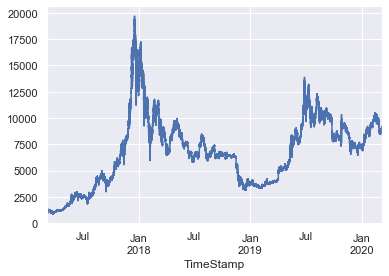

In [39]:
ohlc_data["close"].plot(kind="line")

#### Plot Candle-Sticks

In [46]:
import plotly.graph_objects as go

sample = ohlc_data.tail(60)

fig = go.Figure(data=[go.Candlestick(x=sample.index,
                open=sample.open,
                high=sample.high,
                low=sample.low,
                close=sample.close)])

fig.show()

### Visualize Time of Stress

Lets look at a period where we observed say a 99.95% VaR (value at risk), basically large loss.

In [57]:
perc = 1 - 0.9995
idx = int(ohlc_data.shape[0] * perc) # approximation
# Get 30 minute returns
var = ohlc_data["close"].pct_change(30).dropna().sort_values().iloc[idx]
var

-0.05284625943719967

In [59]:
ohlc_data.loc[ohlc_data["close"].pct_change(30) == var]

,volume,open,high,low,close
TimeStamp,,,,,
2017-12-22 23:46:00,24.938345,13767.01,13900.0,13665.54,13800.03


Based on the above let's look at the trading window from 10pm- 12am during 22-23 Dec 2017

In [60]:
import plotly.graph_objects as go

sample = ohlc_data.loc[pd.date_range(start = "2017-12-22 22:00", end = "2017-12-23 00:00", freq="min")]

fig = go.Figure(data=[go.Candlestick(x=sample.index,
                open=sample.open,
                high=sample.high,
                low=sample.low,
                close=sample.close)])

fig.show()